In [1]:
import numbers

import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch import nn
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as T
from PIL import Image
import genericpath


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# force working on cpu due to memory limitation
#device = torch.device("cpu")




def add_margin(pil_img, top, right, bottom, left, color):
    width, height = pil_img.size
    new_width = width + right + left
    new_height = height + top + bottom
    result = Image.new(pil_img.mode, (new_width, new_height), color)
    result.paste(pil_img, (left, top))
    return result


class YogaPoseDataset(Dataset):

    def __init__(self, dataset_path, size=(256, 192), transform=None, example_images=None):
        if example_images is None:
	        example_images = ["0004225.jpg", "0000008.jpg", "0000313.jpg"]
        self.example_images = dict(zip(example_images, [None] * len(example_images)))
        self.data_path = dataset_path
        self.size = size
        self.transform = transform
        # call to init the data
        self._init_data()

    def _init_data(self):
        images = list()

        for _, directory_class in enumerate(os.listdir(self.data_path)):
            class_path = os.path.join(self.data_path, directory_class)
            for file_name in os.listdir(class_path):
                f = cv2.imread(os.path.join(class_path, file_name), cv2.IMREAD_COLOR)
                f = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)

                if self.transform is not None:
                    f = self.transform(f)

                data = torch.reshape(torch.FloatTensor(f), (3, self.size[0], self.size[1]))

                # format example  images[x][0] -> (label, input)
                # format example  images[x][1] -> [other information]
                # images[x] -> ((class_id, image_tensor), [filename])
                if file_name in self.example_images.keys(): self.example_images[file_name] = len(images)
                images.append((int(directory_class), data))


        np.random.shuffle(images)
        self.images = images

    def __len__(self):
        # returns the number of samples in our dataset
        return len(self.images)

    def getData(self):
        return self.images

    def __getitem__(self, idx):
        """

        Args:
            idx: the index of the sample

        Returns: a tuple (class, input) for the given sample

        """
        return self.images[idx]

    def get_example_images(self ):
        return self.example_images

    def collate_fn(self, data):
        #print(data)
        Xs = torch.stack([x[1] for x in data])
        y = torch.stack([torch.tensor(x[0]) for x in data])
        return Xs, y

In [2]:


DATASET_PATH = './data/images/'
ANNOTATION_PATH = './data/annotations/'
MODEL_NAME = "tpr_a4_256x192"
norm_transform = T.Compose([T.ToTensor(), T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), ])
dataset = YogaPoseDataset(DATASET_PATH, transform=norm_transform)

In [3]:
# get model from torch hub
assert MODEL_NAME in ["tpr_a4_256x192", "tph_a4_256x192"]

transpose_model = torch.hub.load('yangsenius/TransPose:main', MODEL_NAME, pretrained=True)
transpose_model.to(device)

Using cache found in /home/orlando/.cache/torch/hub/yangsenius_TransPose_main
/home/orlando/.cache/torch/hub/yangsenius_TransPose_main/lib/models/transpose_r.py:333: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = temperature ** (2 * (dim_t // 2) / one_direction_feats)


>>Load pretrained weights from url: https://github.com/yangsenius/TransPose/releases/download/Hub/tp_r_256x192_enc4_d256_h1024_mh8.pth
Successfully loaded model  (on cpu) with pretrained weights!


TransPoseR(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=

In [4]:
from TransPose.lib.config import cfg
from TransPose.lib.utils import transforms
from TransPose.lib.core.inference import get_final_preds
from TransPose.visualize import inspect_atten_map_by_locations

In [5]:

train_split_position = (len(dataset) // 10) * 8
val_split_position = train_split_position+len(dataset)//10
trainset = dataset[:train_split_position]
valset = dataset[train_split_position:val_split_position]
testset = dataset[val_split_position:]


In [6]:
OUT_DIR = "./out/"
idx = 0

if not os.path.isdir(OUT_DIR):
    os.makedirs(OUT_DIR)

In [7]:
class PoseClassifier(nn.Module):
    def __init__(self, n_class,
                 transpose_model,device=device, fine_tune=False, pretrained=True):
        super(PoseClassifier, self).__init__()
        layers = []
        dropout = 0.5
        hidden_layers = [128, 512, 512, 512, 512, 256, 128, 128]
        self.tph = transpose_model
        layers.append(nn.Conv2d(17, 128, 3, padding=1))
        self.relu = nn.ReLU()


        #'''
        self.dropout = nn.Dropout(dropout)
        self.conv1 = nn.Conv2d(17, hidden_layers[0], 3, padding=1)
        self.bn1 = nn.BatchNorm2d(hidden_layers[0])
        self.pool1 = nn.MaxPool2d((2, 2), 2)

        self.pool2 = nn.MaxPool2d((3, 3), 3)
        self.conv2 = nn.Conv2d(hidden_layers[0], hidden_layers[1], 3, padding=1)
        self.bn2 = nn.BatchNorm2d(hidden_layers[1])
        self.conv3 = nn.Conv2d(hidden_layers[1], hidden_layers[2], 3, padding=1)
        self.bn3 = nn.BatchNorm2d(hidden_layers[2])
        self.conv4 = nn.Conv2d(hidden_layers[2], hidden_layers[3], 3, padding=1)
        self.bn4 = nn.BatchNorm2d(hidden_layers[3])
        self.conv5 = nn.Conv2d(hidden_layers[3], hidden_layers[4], 3, padding=1)
        self.bn5 = nn.BatchNorm2d(hidden_layers[4])
        #self.conv6 = nn.Conv2d(hidden_layers[4], hidden_layers[-1], 3, padding=1)
        #self.conv7 = nn.Conv2d(hidden_layers[5], hidden_layers[6], 3, padding=1)
        #self.conv8 = nn.Conv2d(hidden_layers[6], hidden_layers[7], 3, padding=1)
        #'''

        self.flatten = nn.Flatten()
        self.lin1 = nn.Linear(hidden_layers[4],hidden_layers[-1])
        self.classifier = nn.Linear(hidden_layers[-1],n_class)



    def forward(self, x):
        out = self.tph(x)
        #print(out.size(),"AFTER TPH")
        out = self.conv1(out)
        out = self.bn1(out)
        #print(out.size(),"AFTER CONV1")
        out = self.pool1(out)
        out = self.relu(out)
        out = self.dropout(out)
        #print(out.size(),"AFTER POOL")
        out = self.conv2(out)
        out = self.bn2(out)
        #print(out.size(),"AFTER CONV2")
        out = self.pool1(out)
        out = self.relu(out)
        out = self.dropout(out)
        #print(out.size(),"AFTER POOL")
        out = self.conv3(out)
        out = self.bn3(out)
        #print(out.size(),"AFTER CONV3")
        out = self.pool2(out)
        out = self.relu(out)
        out = self.dropout(out)
        #print(out.size(),"AFTER POOL")
        out = self.conv4(out)
        out = self.bn4(out)
        #print(out.size(),"AFTER CONV4")
        out = self.pool2(out)
        out = self.relu(out)
        out = self.dropout(out)
        #print(out.size(),"AFTER POOL")
        out = self.conv5(out)
        out = self.bn5(out)
        #print(out.size(),"AFTER CONV5")
        #out = self.pool1(out)
        out = self.flatten(out)
        out = self.relu(out)
        out = self.dropout(out)
        #print(out.size(),"AFTER POOL")
        out = self.lin1(out)
        '''
        out = self.pool1(out)
        out = self.relu(out)
        out = self.dropout(out)
        #print(out.size(),"AFTER POOL")
        out = self.conv6(out)

        #print(out.size(),"AFTER CONV6")
        '''


        out = self.flatten(out)
        out = self.relu(out)
        out = self.dropout(out)
        #print(out.size(),"AFTER FLATTEN")

        out = self.classifier(out)
        return out




In [8]:
num_classes = 107
model = PoseClassifier(n_class=num_classes, transpose_model=transpose_model)
num_epochs = 50
batch_size = 12
learning_rate = 1e-4
learning_rate_decay = 0.99
params_to_update = model.parameters()


def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [9]:
model.to(device)
fine_tune = False
if fine_tune:
    params_to_update = []
    for param in model.tph.parameters():
        param.requires_grad = False
    for p in model.parameters():
        if p.requires_grad == True:
            params_to_update.append(p)
else:
    params_to_update = model.parameters()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=learning_rate)
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=False,collate_fn=dataset.collate_fn)
val_loader = torch.utils.data.DataLoader(dataset=valset,batch_size=batch_size,shuffle=False,collate_fn=dataset.collate_fn)
test_loader = torch.utils.data.DataLoader(dataset=testset,batch_size=batch_size,shuffle=False,collate_fn=dataset.collate_fn)
# Train the model
lr = learning_rate
total_step = len(train_loader)
loss_train = []
loss_val = []
best_accuracy = None
accuracy_val = []

In [10]:
print(len(train_loader))
len(train_loader.dataset)

400


4792

In [11]:
model.to(device)
params_to_update = model.parameters()
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=learning_rate)
# Train the model
lr = learning_rate
total_step = len(train_loader)
loss_train = []
loss_val = []
best_accuracy = None
accuracy_val = []
accuracy_test = []
#best_model = type(model)(num_classes, fine_tune, pretrained) # get a new instance
def train(model,num_epochs=num_epochs,lr=learning_rate):
    for epoch in range(num_epochs):

        model.train()
        correct = 0
        total = 0
        loss_iter = 0

        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            #print(outputs,labels)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_iter += loss.item()


            if (i + 1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

        accuracy = 100 * correct / total
        accuracy_test.append(accuracy)
        print('Training accuracy is: {} %'.format(accuracy))
        loss_train.append(loss_iter / (len(train_loader) * batch_size))

        # Code to update the lr
        lr *= learning_rate_decay
        update_lr(optimizer, lr)

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            loss_iter = 0
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                loss_iter += loss.item()
            loss_val.append(loss_iter / (len(val_loader) * batch_size))
            accuracy = 100 * correct / total
            accuracy_val.append(accuracy)
            print('Validation accuracy is: {} %'.format(accuracy))
            early_stop = False
            patience = 3
            if epoch > patience - 1:
                for j in range(patience - 1):
                    if max(accuracy_val) > list(reversed(accuracy_val))[j]:
                        if "not_improving_epochs" in locals():
                            not_improving_epochs += 1
                        else:
                            not_improving_epochs = 1
                        print('Not saving the model')
                    else:
                        not_improving_epochs = 0
                        best_model = model
                        print("Saving the model")
                        break
                    if not_improving_epochs >= patience:
                        early_stop = True
                        print('Early stopping')
                        break
                    break

    plt.figure(2)
    plt.plot(loss_train, 'r', label='Train loss')
    plt.plot(loss_val, 'g', label='Val loss')
    plt.legend()
    plt.show()

    plt.figure(3)
    plt.plot(accuracy_val, 'r', label='Val accuracy')
    plt.legend()
    plt.show()
    return {"Loss/train": loss_train, "Loss/val": loss_val, "Accuracy/train":accuracy_val, "Accuracy/val": accuracy_test }

def test(model):
    with torch.no_grad():
            correct = 0
            total = 0
            loss_iter = 0
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                loss_iter += loss.item()
            loss_test =(loss_iter / (len(test_loader) * batch_size))
            accuracy = 100 * correct / total
            print('Test accuracy is: {} %'.format(accuracy))
            print('Test Loss: {:.4f}'.format(loss_test))
    return {"Accuracy/test": accuracy, "Loss/test": loss_test}


Epoch [1/3], Step [100/400], Loss: 4.7467
Epoch [1/3], Step [200/400], Loss: 4.6803
Epoch [1/3], Step [300/400], Loss: 4.5510
Epoch [1/3], Step [400/400], Loss: 4.6808
Training accuracy is: 1.7320534223706177 %
Validation accuracy is: 2.337228714524207 %
Epoch [2/3], Step [100/400], Loss: 4.6503
Epoch [2/3], Step [200/400], Loss: 4.4019
Epoch [2/3], Step [300/400], Loss: 4.8228
Epoch [2/3], Step [400/400], Loss: 4.3256
Training accuracy is: 2.963272120200334 %
Validation accuracy is: 2.5041736227045077 %
Epoch [3/3], Step [100/400], Loss: 4.3057
Epoch [3/3], Step [200/400], Loss: 4.0142
Epoch [3/3], Step [300/400], Loss: 4.4980
Epoch [3/3], Step [400/400], Loss: 4.8100
Training accuracy is: 3.714524207011686 %
Validation accuracy is: 3.672787979966611 %


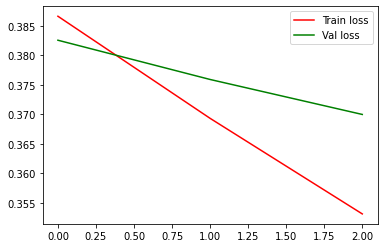

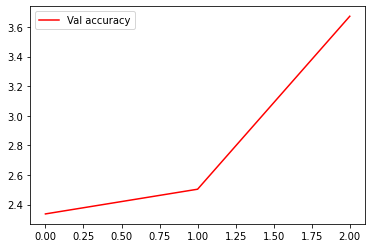

In [12]:
train_values = train(model,num_epochs=3,lr=1e-4)

In [13]:
test_values = test(model)

Test accuracy is: 4.159733777038269 %
Test Loss: 0.3752


In [14]:
def get_model_code():
    import inspect, sys
    from IPython.core.magics.code import extract_symbols

    def new_getfile(object, _old_getfile=inspect.getfile):
        if not inspect.isclass(object):
            return _old_getfile(object)

        # Lookup by parent module (as in current inspect)
        if hasattr(object, '__module__'):
            object_ = sys.modules.get(object.__module__)
            if hasattr(object_, '__file__'):
                return object_.__file__

        # If parent module is __main__, lookup by methods (NEW)
        for name, member in inspect.getmembers(object):
            if inspect.isfunction(member) and object.__qualname__ + '.' + member.__name__ == member.__qualname__:
                return inspect.getfile(member)
        else:
            raise TypeError('Source for {!r} not found'.format(object))

    inspect.getfile = new_getfile
    obj = PoseClassifier
    cell_code = "".join(inspect.linecache.getlines(new_getfile(obj)))
    class_code = extract_symbols(cell_code, obj.__name__)[0][0]
    return class_code

def save_run(train_dict = None, test_dict= None, save_examples = False, ):
    from torch.utils.tensorboard import SummaryWriter
    import numbers, json
    def get_next_logdir():
        from datetime import datetime
        now = datetime.now()
        date_time = now.strftime("%d_%b[%H-%M-%S]")
        multi_val_index = 1
        logs_dir = OUT_DIR + "logs/"
        dir_name = logs_dir + date_time
        while os.path.exists(dir_name):
            multi_val_index += 1
            dir_name = "".join([logs_dir, date_time, "(", str(multi_val_index), ")"])
        return dir_name

    def save_log(value_dict):
        for key,value in value_dict.items():
            if isinstance(value, numbers.Number):
                writer.add_scalar(key, value, 0)
            else:
                for e, e_value in enumerate(value):
                    writer.add_scalar(key, e_value, e)

    dir_name = get_next_logdir()
    model_path = os.path.join(dir_name, "model.ckpt")
    model_json_path = os.path.join(dir_name, "model_params.json")
    model_classcode_path = os.path.join(dir_name, "model_class_code.txt")
    example_images_path = os.path.join(dir_name, "example_images")
    writer = SummaryWriter(log_dir=dir_name)
    model_dict = { "params": {"num_classes": num_classes, "num_epochs": num_epochs, "batch_size": batch_size, "learning_rate": learning_rate, "learning_rate_decay": learning_rate_decay}}

    print("Saving {} in {}".format("model", model_path), end=" ")
    torch.save(model.state_dict(), model_path)
    print("DONE")

    print("Saving {} in {}".format("Logs (if any)", dir_name), end=" ")
    if train_dict is not None: save_log(train_dict)
    if test_dict is not None:save_log(test_dict)
    writer.close()
    print("DONE")

    print("Saving {} in {}".format("parameters", model_json_path), end=" ")
    with open(model_json_path, "w") as jf:
        json.dump(model_dict, jf)
    print("DONE")

    print("Saving {} in {}".format("class code", model_classcode_path), end=" ")
    with open(model_classcode_path, "w") as f:
        f.write(get_model_code())
    print("DONE")

In [15]:
save_run(train_values, test_values, save_examples=True)

Saving model in ./out/logs/12_Dec[21-50-10]/model.ckpt DONE
Saving Logs (if any) in ./out/logs/12_Dec[21-50-10] DONE
Saving parameters in ./out/logs/12_Dec[21-50-10]/model_params.json DONE
Saving class code in ./out/logs/12_Dec[21-50-10]/model_class_code.txt DONE
